<p>
    First we load all the Kaggle data for the titanic set and look at the general characteristics of the data and see the flaws and errors
</p>

In [22]:
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot
%matplotlib inline
titanic = pd.read_csv("train.csv")

# Print the first 5 rows of the dataframe.
print(titanic.head(5))
print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
       P

<p>
    Now that we see the categories(Age,Sex,Embarked) we have to change NaN values and recode characters to numbers for our model we will do so.
</p>

In [23]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

print(titanic["Sex"].unique())
print(titanic["Embarked"].unique())

# Clean Up Data
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['male' 'female']
['S' 'C' 'Q' nan]


<p>
    After cleaning up our training data we can use scikit-learn to create a linear regression model and make predictions cross comparing our training model to evaluate the accuracy.
</p>

In [24]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

<p>
    Now we can assess the accuracy of our predictions 
</p>

In [25]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

def calculate_accuracy(predictions_data):
    # Map predictions to outcomes (only possible outcomes are 1 and 0)
    predictions_data[predictions_data > .5] = 1
    predictions_data[predictions_data <=.5] = 0
    accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
    return accuracy

print calculate_accuracy(predictions)

0.783389450056


/home/wilson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


<p>
    The accuracy of our model is 78.33% .To improve the linear regression model we can vary the output values using logistic regression.
</p>

In [26]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)# Take the mean of the scores (because we have one for each fold)

print(scores.mean())

0.787878787879


<p>
Using LogisticRegression improved the model by a 0.45%. Now we can apply the algorithm to the test_data and generate a submission file to get a score!

First, we need to clean up the test data like we did to the training data then apply the algorithm and store it in a csv
</p>

In [27]:
titanic_test = pd.read_csv("test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v1.csv", index = False)


<p>
    Submission Score: 75.120 For next time lets try improving logistic regression by generating better features to assess survivability. We will add two features: we have observed that richer people are more likely to survive so we can add: Titles in their names b/c unique titles will be richer. Next let's try adding the second category based on the cabin data (only first class cabins were known and first class had a higher chance to survive)
</p>

In [28]:
#use data.io tutorial title code
import re
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))
# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
# Add in the title column.
titanic["Title"] = titles


#after adding the titles we train and reassess the model.
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title"]
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)# Take the mean of the scores (because we have one for each fold)

print(scores.mean())

#we end it with testing out prediction score

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
0.804713804714


<p>
    To can generate a submission file for this version
</p>


In [29]:
# Add Title to the test data
titles = titanic_test["Name"].apply(get_title)
print(pd.value_counts(titles))
# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
# Add in the title column.
titanic_test["Title"] = titles
print(titles.unique())
print(predictors)
print(titanic_test.columns)
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v2.csv", index = False)


Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Name, dtype: int64
[1 3 2 4 7 6 5 10]
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked', u'Title'],
      dtype='object')


<p> 
Next we try a RandomForestClassifier using the predictors we created for the linear model
</p>

0.79797979798


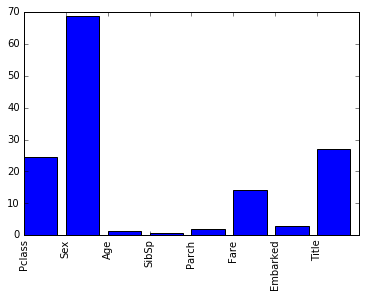

0.811447811448
0.789001122334
0.82379349046


In [32]:
import numpy as np
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print(scores.mean())


<p>
    Now we can map the effectiveness of each category for our model
    
</p>

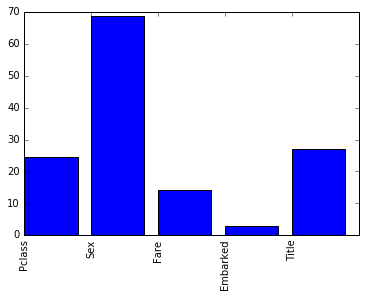

In [33]:
# in this case we are probably overfitting with useless columns so we can remove the less efficient ones 
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

<p>
We can try 3,4,5 of the best options to find the best amount
</p>

In [36]:

predictors = ["Pclass", "Sex", "Fare"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=6, min_samples_leaf=3)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('3 categories ' + str(scores.mean()))


predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('4 categories ' + str(scores.mean()))


predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('5 categories ' + str(scores.mean()))

3 categories 0.789001122334
4 categories 0.811447811448
5 categories 0.82379349046


<p> 
        We see either 4 or 5 is the best and since there might be overfitting we will submit both version and compare it to the test data
        </p>
    

In [38]:
#4 categories
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v3-1.csv", index = False)

#5 categories
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v3-2.csv", index = False)

<p> 
Using 5 leaves was the better model with a score of 0.78469
</p>